<a href="https://colab.research.google.com/github/dkrieger94/intro/blob/master/private.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numbers
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.special import erf

import matplotlib.pyplot as plt

# Some useful time conversion factors
seconds_per_minute = 60.
minutes_per_hour = 60.
hours_per_day = 24.
days_per_year = 365.2422
seconds_per_hour = minutes_per_hour * seconds_per_minute
minutes_per_day = hours_per_day * minutes_per_hour
seconds_per_day = hours_per_day * seconds_per_hour
seconds_per_year = seconds_per_day * days_per_year

A = 204.                    # Budyko approximation constants (W / m**2)
B = 2.17

a = 5.4                     # constant for OLR modification by CO2 (W / m**2)

sigma = 5.6703726226e-08    # Stefan-Boltzmann constant (W / m**2 / K**4)
S0 = 1365.2                 # solar constant (W / m**2)
emss = 0.6                  # atmosphere emissivity

rho_w = 1028.               # density of water (kg / m**3)
cw = 4200.                  # specific heat of liquid water (J / kg / K)

Ts_0 = 286.73               # estimated global mean temperature (1850-1900 avg)

# carbon cycle
k_a = 2.12                  # (GtC / ppm) ---> atmosphere

co2 = 280.                      # pre-industrial atmospheric CO2 concentration (ppm)
g_e = 0.005 / seconds_per_year  # (GtC / ppm) / s
ge_ka = g_e / k_a               # 1 / s
zeta = 10.5                 
mu_0 = 5.0 / seconds_per_year   # Ocean carbon transfer rate (m / s)

tau_l = 41. * seconds_per_year  # reference lifetime of land carbon (yr)
q_10 = 1.8                      # increase in respiration with a 10K temp. increase
beta_fertil = 0.4               # CO2 fertilization factor
npp_0 = 60. / seconds_per_year  # pre-industrial net primary productivity (GtC / yr)
cl_0 = 2500.                    # pre-industrial land carbon storage (GtC)

emss_0 = 36. / seconds_per_year # (GtC / s)

class ESM:

    def __init__(self,
                 initial_state={'Ts':Ts_0, 'Td':Ts_0-10},
                 solar_cnst=0.25 * S0,
                 albedo_atm=0.0,
                 albedo_land=0.29,
                 albedo_icefree=0.2,
                 albedo_ice=0.6,
                 albedo_ref_temperature=273.15,
                 albedo_b=0.05,
                 albedo_carbon_coeff=-0.01,
                 emissivity=emss,
                 emissivity_gradient=0.01,
                 emissivity_t_ref=288.,
                 depth_s=75.0,
                 depth_d=3750.0,
                 emissions_scenario=emss_0,
                 transient_rad_resp=0.0,
                 mixing_scale=3.2,
                 lin_olr=False,
                 use_constant_albedo_land=True,
                 use_constant_albedo_icefree=True,
                 use_constant_emissivity=True,
                 reference_year=1850,
                 active_components=3):
      
        # albedo parameters
        self.albedo_atm = albedo_atm  # atmospheric albedo
        self.albedo_land = albedo_land
        self.albedo_icefree = albedo_icefree  # land albedo in hothouse climate
        self.albedo_ice = albedo_ice  # land albedo in snowball climate
        self.albedo_ref_temperature = albedo_ref_temperature  # reference temperature for albedo transition zone
        self.albedo_b = albedo_b  # albedo error function tuning parameter
        self.albedo_carbon_coeff = albedo_carbon_coeff  # albedo dependence on carbon
        self.use_constant_albedo_land = use_constant_albedo_land
        self.use_constant_albedo_icefree = use_constant_albedo_icefree

        self.solar_cnst = solar_cnst
        self.lin_olr = lin_olr

        # emissivity
        self.emss = emissivity
        self.emss_gradient = emissivity_gradient  # change in emissivity with temperature (1 / K)
        self.emss_t_ref = emissivity_t_ref  # reference temperature for which emissivity = self.emss
        self.use_constant_emissivity = use_constant_emissivity

        # atmosphere-ocean coupling parameters
        self.eta = mixing_scale
        self.lambda_t = transient_rad_resp

        # pre-industrial ocean carbon storage [ GtC ]
        self.cl_0 = cl_0
        self.ca_0 = co2 * k_a
        self.co_0 = 6 * zeta * self.ca_0
        self.cs_0 = self.co_0 * (depth_s) / (depth_s + depth_d)
        self.cd_0 = self.co_0 - self.cs_0
        self.nu = zeta * (self.ca_0 / self.cs_0)

        # Anthropogenic emissions
        self.reference_year = reference_year
        self.Ts_0 = Ts_0     # estimated global mean temperature (1850-1900 avg)

        if isinstance(emissions_scenario, numbers.Number):
            # constant emission scenario                             (GtC / yr)
            self.em = lambda t: emissions_scenario
            print(1)
        elif callable(emissions_scenario):
            # Time dependent function                                (GtC / yr)
            self.em = emissions_scenario
            print(2)
        elif hasattr(emissions_scenario, '__len__'):
            # Time series (filename / array)                         (GtC / yr)
            print(3)
            if isinstance(emissions_scenario, str):
                # Assuming a filename is given as string
                em_data = np.array(pd.read_csv(emissions_scenario, sep=',')).T
                print(31)
            else:
                em_data = np.asanyarray(emissions_scenario)
                print(32)

            # create interpolation function from data points
            interp_fun = interp1d(*em_data,
                                  kind='linear', bounds_error=False,
                                  fill_value=(em_data[1, 0], em_data[1,-1]))
            print(interp_fun)
            self.em = lambda time: interp_fun(time)
            print(self.em)
            print(self.em(1800))
            print((em_data[1, 0], em_data[1,-1]))
        else:
            raise ValueError(
                "Parameter 'emissions' must be a scalar, a filename (string),"
                " a Nx2 sequence or a callable function")

        #-----------------------------------------------------------------------
        # Model state initialization:
        #-----------------------------------------------------------------------
        self.model_state = {}

        if isinstance(initial_state, dict):
            vnames = initial_state.keys()
            assert 'Ts' in vnames,"Model state must contain at least 'Ts'"

            self.model_state['Ts'] = initial_state['Ts']
            if 'Td' not in vnames:
                self.model_state['Td'] = initial_state['Ts'] - 10.0
            else:
                self.model_state['Td'] = initial_state['Td']

            if 'Ca' not in vnames: # Atmospheric   carbon storage (GtC)
                self.model_state['Ca'] = self.ca_0
            else: 
                self.model_state['Ca'] = initial_state['Ca'] * k_a

            if 'Cs' not in vnames: # Surface Ocean carbon storage (GtC)
                self.model_state['Cs'] = self.cs_0
            else:
                self.model_state['Cs'] = initial_state['Cs']

            if 'Cd' not in vnames: # Deep Ocean    carbon storage (GtC)
                self.model_state['Cd'] = self.cd_0
            else:
                self.model_state['Cd'] = initial_state['Cd']

            if 'Cl' not in vnames: # Terrestrial   carbon storage (GtC)
                self.model_state['Cl'] = self.cl_0
            else:
                self.model_state['Cl'] = initial_state['Cl']

        elif np.isscalar(initial_state):
            self.model_state['Ts'] = initial_state
            # ocean layer initialized to be 10 degrees colder than the surface layer
            self.model_state['Td'] = self.model_state['Ts'] - 10.0
            self.model_state['Ca'] = self.ca_0
            self.model_state['Cs'] = self.cs_0
            self.model_state['Cd'] = self.cd_0
            self.model_state['Cl'] = self.cl_0

        else:
            raise ValueError("Wrong model initialization")

        # create instances of state variables from init dictionary
        for k, v in self.model_state.items():
            setattr(self, k, v)

        self.num_active_components = active_components
        self.num_active_variables = np.array([1,2,6])[active_components-1]


        #-----------------------------------------------------------------------
        # Integration time scales
        #-----------------------------------------------------------------------
        self.depth_s = depth_s      # characteristic depth for Ts   (m)
        self.tau_s = self.depth_s * rho_w * cw # time scale for integration

        self.depth_d = depth_d      # characteristic depth for Ts   (m)
        self.tau_d = self.depth_d * rho_w * cw # time scale for integration

    #---------------------------------------------------------------------------
    #---------------   Definition Atmosphere-Ocean processes    ----------------
    #---------------------------------------------------------------------------
    def compute_albedo(self, Ts, Ca):
        return self.albedo_atm + self.compute_albedo_land(Ts, Ca) * (1 - self.albedo_atm) ** 2

    def compute_albedo_land(self, Ts, Ca):
        if self.use_constant_albedo_land:
            return self.albedo_land
        else:
            tmp = erf(self.albedo_b * (Ts - self.albedo_ref_temperature))
            tmp = self.albedo_ice * (1.0 - tmp) + self.compute_albedo_icefree(Ca) * (1.0 + tmp)
            return tmp / 2.0

    def compute_albedo_icefree(self, Ca):
        if self.use_constant_albedo_icefree:
            return self.albedo_icefree
        elif (Ca / k_a) > 1.0:
            return self.albedo_icefree + self.albedo_carbon_coeff * np.log(Ca / k_a)
        else:
            return self.albedo_icefree

    def compute_emss(self, Ts):
        if self.use_constant_emissivity:
            return 1.0 - 0.5 * self.emss
        else:
            return 1.0 - 0.5 * (self.emss + self.emss_gradient * (Ts - self.emss_t_ref))

    def compute_ASR(self, Ts, Ca):
        return self.solar_cnst * (1 - self.compute_albedo(Ts, Ca))

    def compute_OLR(self, Ts, Ca):
        if self.lin_olr:
            return A + B * (Ts - 273.15)
        if (Ca / k_a) > 1.0:
            return self.compute_emss(Ts) * sigma * Ts ** 4 - a * np.log(Ca/k_a)
        else:
            return self.compute_emss(Ts) * sigma * Ts ** 4

    def compute_NRI(self, Ts, Ca):
        return  self.compute_ASR(Ts, Ca) - self.compute_OLR(Ts, Ca)

    def compute_DSI(self, Ts, Td):
        return (self.eta + self.lambda_t) * (Ts - Td)

    #---------------------------------------------------------------------------
    #------------------           Carbon Cycle             ---------------------
    #---------------------------------------------------------------------------
    def gas_exchange_rate(self, Ts):
        # gas_exchange_rate (s^-1)
        return ge_ka

    def compute_fs(self, Ts, Ca, Cs):
        """Ocean carbon uptake
        """
        dCo = self.nu * (Cs - self.cs_0)
        return self.gas_exchange_rate(Ts) * ((Ca - self.ca_0) - dCo)

    def compute_fd(self, Cs, Cd):
        tmp_s = (Cs - self.cs_0) / self.depth_s
        tmp_d = (Cd - self.cd_0) / self.depth_d
        return mu_0 * (tmp_s - tmp_d)

    def compute_fl(self, Ca, Cl, Ts):
        return self.compute_NPP(Ca) - self.compute_respiration(Ts, Cl)

    def compute_NPP(self, Ca):
        # Here Ca units must be ppm
        return npp_0 * (1.0 + beta_fertil * np.log(Ca / self.ca_0))

    def compute_respiration(self, Ts, Cl):
        # Ts must be dTs: The surface air temperature change since pre-industrial
        return (Cl / tau_l) * q_10 ** ((Ts - self.Ts_0) / 10.)


    #---------------------------------------------------------------------------
    #------------------   Model tendencies and components  ---------------------
    #---------------------------------------------------------------------------

    # Instead of evaluating conditional statement inside 'self.compute_imbalance',
    # the model is constructed according to the number of active components

    def model_constructor(self):

        if self.num_active_components == 1:

            def _compute_imbalance(time, state):
                return self.compute_NRI(state, self.Ca) / self.tau_s

        elif self.num_active_components == 2:

            def _compute_imbalance(time, state):
                Ts, Td = state
                Ns = self.compute_NRI(Ts, self.Ca) / self.tau_s
                Nd = self.compute_DSI(Ts, Td) / self.tau_d
                return np.array([Ns - Nd, Nd])

        elif self.num_active_components == 3:
            # self.ca is not a state variable unless emissions are considered
            def _compute_imbalance(time, state):
                Ts, Td, Cs, Cd, Cl, Ca = state
                Ns = self.compute_NRI(Ts, Ca) / self.tau_s
                Nd = self.compute_DSI(Ts, Td) / self.tau_d

                Ncs = self.compute_fs(Ts, Ca, Cs)
                Ncd = self.compute_fd(Cs, Cd)
                Ncl = self.compute_fl(Ca, Cl, Ts)

                return np.array([Ns - Nd, Nd, Ncs - Ncd, Ncd, Ncl, self.em(time) - Ncl - Ncs])
        else:
            raise ValueError("Something went wrong when constructing the model")

        return _compute_imbalance

    #---------------------------------------------------------------------------
    #------------------          Model numerics            ---------------------
    #---------------------------------------------------------------------------
    def model_info(self):
        print("Running [Atmosphere, Ocean, Carbon] : ", self.num_active_components)
        print('Surface temperature: ', self.model_state['Ts'], ' [K]')
        print('Ocean temperature: ', self.model_state['Td'], ' [K]')
        print('Surface albedo: ', self.compute_albedo(self.model_state['Ts'], self.model_state['Ca']), ' [-]')
        print('Land albedo: ', self.compute_albedo_land(self.model_state['Ts'], self.model_state['Ca']), ' [-]')
        print('CO2: ', self.model_state['Ca'] / k_a, ' [ppmv]')
        print('Atmospheric carbon:', self.model_state['Ca'], ' [GtC]')
        print('Land carbon:', self.model_state['Cl'], ' [GtC]')
        print('Mixed Layer carbon:', self.model_state['Cs'], ' [GtC]')
        print('Deep Ocean carbon:', self.model_state['Cd'], ' [GtC]')
        print('ASR: ', self.compute_ASR(self.model_state['Ts'], self.model_state['Ca']), ' [W/m^2]' )
        print('OLR: ', self.compute_OLR(self.model_state['Ts'], self.model_state['Ca']), ' [W/m^2]' )
        print('NRI: ', self.compute_NRI(self.model_state['Ts'], self.model_state['Ca']), ' [W/m^2]' )
        print('DSI: ', self.compute_DSI(self.model_state['Ts'], self.model_state['Td']), ' [W/m^2]' )

    def integrate(self, sim_time=1.0, out_freq=None,
                  update_state=True, verbose=False, is_relative_time=True):
        '''Parameters
            sim_time: Integration time in years (simulation length, end year, array containing years)
            out_freq: Interval to sample model outputs (years)
            update_state: Update the models state after integration
            is_relative_time: time relative to reference_year
        '''

        print('--------------- Initial state -----------')
        self.model_info()

        # Handling of model integration time:
        if np.isscalar(sim_time):

            if is_relative_time:
                if out_freq is None:
                    time = np.array([0.0, sim_time,])
                else:
                    time = np.arange(0.0, sim_time, out_freq)
                time += self.reference_year
            else:
                assert sim_time>self.reference_year,'Time travel not supported :)'

                if out_freq is None:
                    time = np.array([self.reference_year, sim_time,])
                else:
                    time = np.arange(self.reference_year, sim_time, out_freq)

        elif hasattr(sim_time, '__len__') and (not isinstance(sim_time, str)):

            if not np.all(sim_time >= 0):
                ValueError("When 'sim_time' is a sequence it must contain positive values only")
            time = np.asanyarray(sim_time)
            if is_relative_time:
                time += self.reference_year # convert to absolute time
        else:
            raise ValueError("Parameter 'sim_time' must be a scalar or a sequence containing time in years")
        
        # convert time to seconds
        # time *= seconds_per_year

        # Handling emission scenarios:

        # Storing an array-like copy of initial condition:
        vlist = "Ts,Td,Cs,Cd,Cl,Ca".split(',')[:self.num_active_variables]

        Tstart = np.array([self.model_state[vname] for vname in vlist])

        # construct callable function for rhs (model tendencies):
        rhs = lambda t, x: self.model_constructor()(t, x) * seconds_per_year

        # Integrate using odeint
        (Tequim, info) = odeint(rhs, Tstart, time,
                                Dfun=None,
                                full_output=True,
                                printmessg=verbose, tfirst=True)
        
        if self.num_active_components > 1:
            Tequim = Tequim.squeeze()

        if verbose:
            print(info)

        # update model Equilibrium Temperature with last computed stage:
        updated_state = {}
        for i, vname in enumerate(vlist):
            updated_state[vname] = Tequim[:, i]

        if update_state:
            # update model Equilibrium Temperature with last computed stage:
            for k, v in updated_state.items():
                self.model_state[k] = v[-1]

        print('----- Model state after {:.2f} years ------'.format(sim_time))
        self.model_info()

        # return specified integration time-series:
        if time.size > 2:
            return time, updated_state
        else:
            return updated_state

if __name__ == "__main__":

    model = ESM(initial_state={'Ts':Ts_0, 'Td':Ts_0-10., 'Ca':280},
                use_constant_albedo_land=True,
                emissivity_gradient=0.01,
                emissions_scenario='https://raw.githubusercontent.com/dkrieger94/intro/master/scen/historical.txt',
                active_components=3)
    
    # model.integrate(sim_time=200., out_freq=1., update_state=True)

    # print(model.emissions)
    print(model.em(1900))



3
31
<function ESM.__init__.<locals>.<lambda> at 0x7f01b5de4a70>
0.028092000000000002
(0.009351, 36.441388)
1.953614


In [43]:
pd.__version__

'1.1.5'

TypeError: ignored

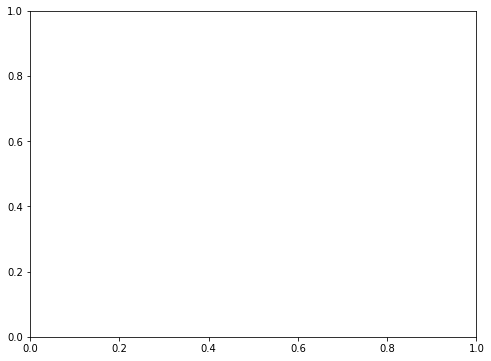

In [ ]:
scenarios = ['historical']
colors = ['red', 'green', 'orange', 'blue', 'purple', 'darkgray']
years = np.linspace(1850, 2100, 1000)
t_scenarios = np.zeros((len(scenarios), len(years)))

fig, ax = plt.subplots(figsize=(8,6))

for i, scenario in enumerate(scenarios):
    ### run model here for scenario and settings
    output = 0
    t_scenarios[i, :] = output['Ts']

    ax.plot(time, t_scenarios[i, :]-Ts_0, color=colors[i], label=scenario)

ax.legend(label='Scenario')
ax.set_xlabel('Year')
ax.set_ylabel('$\Delta\,T from pre-industrial [K]')

